In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba 
from numba import prange
from joint_QR import *

In [2]:
from typing import Union

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

# Generate some fake data

In [95]:
np.random.seed(0)

In [96]:
x_vals = np.concatenate([np.arange(-0.99,1, 0.01),
                         np.arange(-0.99,1, 0.01),
                        np.arange(-0.99,1, 0.01),
                        np.arange(-0.99,1, 0.01)])

y_vals_true = 0 + 1*x_vals + np.random.normal(0,1,len(x_vals))

In [97]:
len(y_vals_true)

796

## First Plot: Single sample for multiple tau

In [98]:
# Example X_vals and tau_vals
tau_vals = np.arange(0,1,0.05)[1:]



Text(0, 0.5, 'Y')

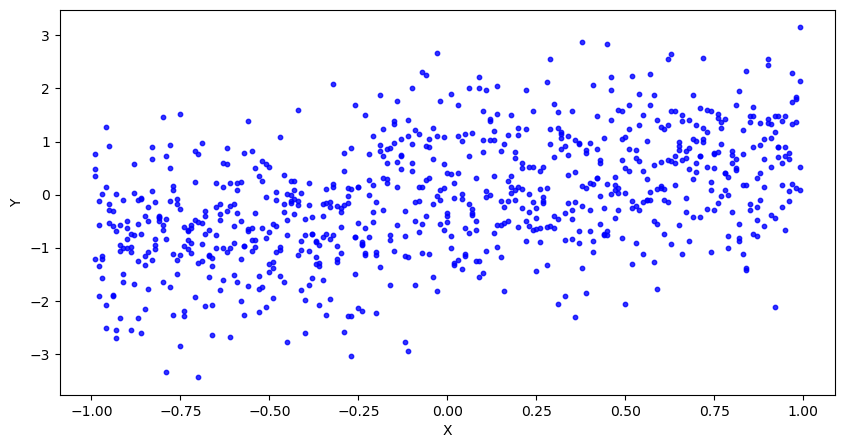

In [99]:
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(x_vals, y_vals_true, s=10, color='blue', alpha=0.8)
    
ax.set_xlabel('X')
ax.set_ylabel('Y')

# MCMC Sampling

- Block (Metropolis in Gibbs):
- Block 1: Eta Function components, GP, lambda and rho
- Block 2: Remaining, mu, gamma, sigma1 and sigma2

# MCMC Sampling Loop with Approximation

Setting priors for 
- W $\sim$ GP Thingy (Just draw from multviariate)?
- $\kappa^2 \sim  IG(3,1/3)$
- $\lambda^2 \sim Ga(5,1/10)$
- $\rho \sim Unif(0,1)$
- $\sigma_1, \sigma_2 \sim Ga(2,2)$
- $\mu \sim N(0,1)$
- $\gamma \sim N(0,1)$

Block metropolis with blocks
- W, $\kappa^2$, $\lambda^2$, $\rho$
-  $\sigma_1, \sigma_2, \mu, \gamma$

In [100]:
from scipy.stats import multivariate_normal, gamma
import time
from scipy.linalg import block_diag

In [101]:
knot_points_t = np.arange(0.1,1,0.05)

In [102]:
# Set MCMC Parameters
s = time.time()
n_steps = 20000
lol_cnt = 0

# Set adaptive metropolis step sizes
C_1 = 0.9
lambda_step_size_1 = 3
alpha_step_size_1 = 0.2
step_sizes_1 = C_1/(np.arange(1,n_steps+10)**alpha_step_size_1)
a_target_1 = 0.4

C_2 = 0.9
lambda_step_size_2 = 3
alpha_step_size_2 = 0.2
step_sizes_2 = C_2/(np.arange(1,n_steps+10)**alpha_step_size_2)
a_target_2 = 0.4

# Set knot points for approx
#tau_grid_expanded = np.arange(0,1.01,0.01)
tau_grid_expanded = np.arange(-0.01,1.02,0.01)
tau_grid = np.arange(0.01,1.0,0.01)

knot_points_grid = np.arange(0.1,1,0.1)
knot_points_t = knot_points_grid
m = len(knot_points_t)  # no knots


# Calc covariance matrix 
knot_sub_ids = np.array(m*[0] + m*[1]).reshape(-1,1)
knot_points_t = np.concatenate([knot_points_t,
                            knot_points_t]).reshape(-1,1)



knot_points = np.hstack([knot_sub_ids, knot_points_t])

tau_input_test_0 = np.vstack([np.zeros(len(tau_grid)), tau_grid]).T
tau_input_test_1 = np.vstack([np.ones(len(tau_grid)), tau_grid]).T
tau_input = np.vstack([tau_input_test_0, tau_input_test_1])

tau_input_test_0_expanded = np.vstack([np.zeros(len(tau_grid_expanded)),
                                       tau_grid_expanded]).T
tau_input_test_1_expanded= np.vstack([np.ones(len(tau_grid_expanded)),
                                       tau_grid_expanded]).T

tau_input_expanded = np.vstack([tau_input_test_0_expanded,
                                tau_input_test_1_expanded])



#### Initialize variables

## GP Related hyperparameters
kappa_current = 1
rho_current = 0
lambd_current = 6.5
alpha_kappa = 5
beta_kappa = 1/3


## Regression related parametrs
mu_current = 0
gamma_current = 0
sigma_1_current = 2
sigma_2_current = 2


#### W samples
# calc covariance matrix
cov_mat_knots_current = covariance_mat_single_var(knot_points,
                             kappa=kappa_current,
                             rho=rho_current,
                             lambd=lambd_current)

w_knot_points_current = np.random.multivariate_normal(np.zeros(m*2),
                                             cov_mat_knots_current)


# Generate sample of GP approx
w_approx_current = calc_knot_approx_v2(tau_input_expanded,
                                knot_points_grid,
                                   cov_mat_knots_current,
                                   w_knot_points_current,
                                   kappa_current,
                                   rho_current,
                                   lambd_current)



# Storage variables
w_approx_store = []
kappa_store = []
lambda_store = []
rho_store = []

sigma_1_store = []
sigma_2_store = []
mu_store = []
gamma_store = []


kappa_accept = 0
lambda_accept = 0
rho_accept= 0 
sigma_accept = 0
mu_accept = 0
gamma_accept = 0

### initialise adaptive metropolis

# Block 1
am_lamb_block1 = (2.38**2)/(2*m+1)
log_am_lamb_block1 = np.log(am_lamb_block1)
am_cov_block1 = block_diag(cov_mat_knots_current, np.eye(1))#np.eye(len(w_knot_points_current)+2)

mu_block1 = np.concatenate([w_knot_points_current,
                               np.array([lambd_current])])
                              # np.array([rho_current])])
    
    
# Block 2
am_lamb_block2 = (2.38**2)/4
log_am_lamb_block2 = np.log(am_lamb_block2)
am_cov_block2 = np.diag([np.sqrt(5),np.sqrt(5),1,1])
mu_block2 = np.concatenate([np.array([mu_current]),
                               np.array([gamma_current]),
                               np.array([np.log(sigma_1_current),
                                         np.log(sigma_2_current)])])



checks = []
prop_check1 = []
prop_check2 = []
a_check = []

block_1_accept_cnts = 0
block_2_accept_cnts = 0
blk2_check = []

eps_1 = 0#1e-6
eps_2 = 0#1e-6

base_quantile_mean = 0.0
base_quantile_sd = 1.0

In [103]:
cov_store_2 = []
mu_block_store_2 =[]
am_params_store_2 = []
a_check2 = []

In [104]:
from scipy.stats import gamma

update_block_1 = np.concatenate([w_knot_points_current,
                           np.array([lambd_current])])

update_block_2 = np.concatenate([np.array([mu_current]),
                           np.array([gamma_current]),
                           np.array([np.log(sigma_1_current),
                                     np.log(sigma_2_current)])])

In [105]:
for mc_i in range(n_steps): 
    
    #print(mc_i)
    
    #### Generate Sample for W, kappa, tau, lamdba
    
    am_lamb_block1 = np.exp(log_am_lamb_block1)
    proposal_vec  = np.random.multivariate_normal(update_block_1,
                                                 am_lamb_block1*am_cov_block1+np.eye(len(mu_block1))*eps_1)
    
    w_knot_prop = proposal_vec[0:len(w_knot_points_current)]
    lambd_prop = proposal_vec[len(w_knot_points_current)]
    
    #log_rho_prop = proposal_vec[len(w_knot_points_current)+2]
    #rho_prop = sigmoid(proposal_vec[len(w_knot_points_current)+1])
    
    
    prop_check1.append(proposal_vec)
    
    rho_prop = 0 #1/(1+e**log_rho_prop)
    
    cov_mat_knot_prop = covariance_mat_single_var(knot_points,
                                                  kappa=1,
                                                  rho=rho_prop,
                                                  lambd=lambd_prop,
                                                  with_kappa=False)
    
    # Update w_sample
    w_approx_prop = calc_knot_approx_v2(tau_in=tau_input_expanded,
                                        knot_points_t=knot_points_grid,
                                        cov_mat_knots=cov_mat_knot_prop,
                                        w_knot_points=w_knot_prop,
                                        kappa=1,
                                        rho=rho_prop,
                                        lambd=lambd_prop,
                                        with_kappa=False)

    # Calc likelihood
    ll_prop = eval_ll(y_vals_true,
                      x_vals,
                      w_samples_1=w_approx_prop[0:103],
                      w_samples_2=w_approx_prop[103:],
                      sigma_1=sigma_1_current,
                      sigma_2=sigma_2_current,
                      tau_grid=tau_grid,
                      tau_grid_expanded=tau_grid_expanded,
                      mu=mu_current,
                      gamma=gamma_current,
                      base_quantile_mean=base_quantile_mean,
                      base_quantile_sd=base_quantile_sd,
                      base_quantile_v=1,
                      base_quantile_dist='norm')

    ll_curr = eval_ll(y_vals_true,
                      x_vals,
                      w_samples_1=w_approx_current[0:103],
                      w_samples_2=w_approx_current[103:],
                      sigma_1=sigma_1_current,
                      sigma_2=sigma_2_current,
                      tau_grid=tau_grid,
                      tau_grid_expanded=tau_grid_expanded,
                      mu=mu_current,
                      gamma=gamma_current,
                      base_quantile_mean=base_quantile_mean,
                      base_quantile_sd=base_quantile_sd,
                      base_quantile_v=1,
                      base_quantile_dist='norm')    

    checks.append((ll_prop, ll_curr))
    
    # Prior Probs
    """
    log_prior_prop = logpdf_mvn(w_knot_prop,np.zeros(m*2),cov_mat_knot_prop) +\
                     gamma.logpdf(1/kappa_prop**(2),  a=3, scale=3) +\
                     gamma.logpdf(lambd_prop**(2),  a=5, scale=10) 
    
    
    log_prior_current = logpdf_mvn(w_knot_points_current,np.zeros(m*2),cov_mat_knots_current) +\
                 gamma.logpdf(1/kappa_current**(2),  a=3, scale=3) +\
                 gamma.logpdf(lambd_current**(2),  a=5, scale=10) 
    """
    
    log_prior_prop = logpdf_t(w_knot_prop,
                              np.zeros(m*2),
                              (beta_kappa/alpha_kappa)*cov_mat_knot_prop,
                              2*alpha_kappa) +\
                     gamma.logpdf(lambd_prop**2,  a=5, scale=10) 
    
    
    log_prior_current = logpdf_t(w_knot_prop,
                              np.zeros(m*2),
                              (beta_kappa/alpha_kappa)*cov_mat_knots_current,
                              2*alpha_kappa) +\
                 gamma.logpdf(lambd_current**2,  a=5, scale=10) 
    
    
    # Transition Probs
    log_proposal_prop = 0
    

    
    current_vec = np.concatenate([w_knot_points_current,
                               np.array([lambd_current])])
    

    
    log_proposal_current = 0
    
    trans_weight_1 = (ll_prop + log_prior_prop + log_proposal_current) - \
                       (ll_curr + log_prior_current + log_proposal_prop) 
    
    if np.isnan(trans_weight_1):
        print('Transition Error 1')
        trans_weight_1 = -1e99
    a = np.exp(min(0,  trans_weight_1))
    
    a_check.append(a)
    #print(a)
    if np.random.uniform(0,1) < a:
        w_knot_points_current = w_knot_prop
        lambd_current = lambd_prop
        rho_current = rho_prop
        
        block_1_accept_cnts += 1
    else: 
        w_knot_points_current = w_knot_points_current
        lambd_current = lambd_current
        rho_current = rho_current
    
    # Update w     
    cov_mat_knots_current = covariance_mat_single_var(knot_points,
                             kappa=1,
                             rho=rho_current,
                             lambd=lambd_current,
                             with_kappa=False)
    
    w_approx_current = calc_knot_approx_v2(tau_in=tau_input_expanded,
                                   knot_points_t=knot_points_grid,
                                   cov_mat_knots=cov_mat_knots_current,
                                   w_knot_points=w_knot_points_current,
                                   kappa=1,
                                   rho=rho_current,
                                   lambd=lambd_current,
                                   with_kappa=False)
    
    
    
    # Update AM sampling parameters
    update_block_1 = np.concatenate([w_knot_points_current,
                               np.array([lambd_current])])
                              # np.array([np.log(rho_current/(1-rho_current))])])
    

    
    # Adaptive metropolis update for block 1
    log_am_lamb_block1 = log_am_lamb_block1 + step_sizes_1[mc_i]*(a - a_target_1)
    #print(log_am_lamb_block1)
    mu_block1_update = mu_block1 + step_sizes_1[mc_i]*(update_block_1 - mu_block1)
    
    am_cov_block1 =  am_cov_block1 + \
                    step_sizes_1[mc_i]*( (update_block_1 - mu_block1).reshape(-1,1) @\
                                                  ((update_block_1 - mu_block1).reshape(-1,1).T) - am_cov_block1)
    
    mu_block1 = mu_block1_update
    
    # Store generated variables
    w_approx_store.append(w_approx_current)
    kappa_store.append(kappa_current)
    lambda_store.append(lambd_current)
    
    
    if ll_prop > 1e99:
        print('break 1')
        break
    if ll_prop < -1e99:
        print('break 1')
        break
    
    ############ BLOCK 2 ################
    #### Sample mu, gamma, sigma1 and sigma2  ####   
    am_lamb_block2 = np.exp(log_am_lamb_block2)
    
    proposal_vec2  = np.random.multivariate_normal(update_block_2,
                                                 am_lamb_block2*am_cov_block2+eps_2*np.eye(len(mu_block2)) )
    
    blk2_check.append((update_block_2, am_lamb_block2, am_cov_block2))

    mu_prop = proposal_vec2[0]
    gamma_prop = proposal_vec2[1]
    
    sigma_1_prop = np.exp(proposal_vec2[2])
    sigma_2_prop = np.exp(proposal_vec2[3])

    
    prop_check2.append((proposal_vec2, mu_block2))
    

    # Calc likelihood
    ll_prop = eval_ll(y_vals_true,
                      x_vals,
                      w_samples_1=w_approx_current[0:103],
                      w_samples_2=w_approx_current[103:],
                      sigma_1=sigma_1_prop,
                      sigma_2=sigma_2_prop,
                      tau_grid=tau_grid,
                      tau_grid_expanded=tau_grid_expanded,
                      mu=mu_prop,
                      gamma=gamma_prop,
                      base_quantile_mean=base_quantile_mean,
                      base_quantile_sd=base_quantile_sd,
                      base_quantile_v=1,
                      base_quantile_dist='norm')

    ll_curr = eval_ll(y_vals_true,
                      x_vals,
                      w_samples_1=w_approx_current[0:103],
                      w_samples_2=w_approx_current[103:],
                      sigma_1=sigma_1_current,
                      sigma_2=sigma_2_current,
                      tau_grid=tau_grid,
                      tau_grid_expanded=tau_grid_expanded,
                      mu=mu_current,
                      gamma=gamma_current,
                      base_quantile_mean=base_quantile_mean,
                      base_quantile_sd=base_quantile_sd,
                      base_quantile_v=1,
                      base_quantile_dist='norm')    

    
    checks.append((ll_prop, ll_curr))
    # Take metropolis step
    if ll_prop > 1e99:
        print('break 2')
        break
    if ll_prop < -1e99:
        print('break 2')
        break
    if np.isnan(ll_prop):
        break
    
        
    log_prior_prop = norm.logpdf(mu_prop,0,2) +\
                     norm.logpdf(gamma_prop,0,2) +\
                     gamma.logpdf(sigma_1_prop,  a=6, scale=1/2) +\
                     gamma.logpdf(sigma_2_prop,  a=6, scale=1/2) 
    
    
    log_prior_current = norm.logpdf(mu_current,0,2) +\
                        norm.logpdf(gamma_current,0,2) +\
                        gamma.logpdf(sigma_1_current,  a=6, scale=1/2) +\
                        gamma.logpdf(sigma_2_current,  a=6, scale=1/2) 
    
    """
    log_proposal_prop = multivariate_normal.logpdf(proposal_vec2,
                                                  mu_block2,
                                                  am_lamb_block2*am_cov_block2) \
                                                    - np.log(sigma_1_prop) \
                                                    - np.log(sigma_2_prop)
    """
    log_proposal_prop = 0  -2.0* sigma_1_prop   - 2.0*sigma_2_prop
    
    
    current_vec2 = np.concatenate([np.array([mu_current]),
                               np.array([gamma_current]),
                               np.array([np.log(sigma_1_current),
                                         np.log(sigma_2_current)])])
    
    """
    log_proposal_current = multivariate_normal.logpdf(current_vec2,
                                                  mu_block2,
                                                  am_lamb_block2*am_cov_block2) \
                                                    - np.log(sigma_1_current) \
                                                    - np.log(sigma_2_current)
    """
    log_proposal_current = 0  - 2.0*sigma_1_current    -2.0* sigma_2_current
                                                    
    
    #if (ll_prop + log_prior_prop + log_proposal_current) > 0:
    #    break
        
    a_2 = np.exp(min(0,  ((ll_prop + log_prior_prop + log_proposal_current) \
                     - (ll_curr +log_prior_current + log_proposal_prop)) ))
    
    a_check2.append((a_2, 
                     ll_prop + log_prior_prop + log_proposal_current,
                     ll_curr +log_prior_current + log_proposal_prop))
    
    #print(a)
    if np.random.uniform(0,1) < a_2:
        mu_current = mu_prop
        gamma_current = gamma_prop
        sigma_1_current = sigma_1_prop
        sigma_2_current = sigma_2_prop
        
        block_2_accept_cnts += 1
    else: 
        mu_current = mu_current
        gamma_current = gamma_current
        sigma_1_current = sigma_1_current
        sigma_2_current = sigma_2_current
    
    
    sigma_1_store.append(sigma_1_current)
    sigma_2_store.append(sigma_2_current)
    mu_store.append(mu_current)
    gamma_store.append(gamma_current)
    
    # Update AM block 2 sampling parameters
    update_block_2 = np.concatenate([np.array([mu_current]),
                               np.array([gamma_current]),
                               np.array([np.log(sigma_1_current),
                                         np.log(sigma_2_current)])])

    
    # Adaptive metropolis update for block 1
    log_am_lamb_block2 = log_am_lamb_block2 + step_sizes_2[mc_i]*(a_2 - a_target_2)
    #print(log_am_lamb_block1)
    mu_block2_update = mu_block2 + step_sizes_2[mc_i]*(update_block_2 - mu_block2)
    
    am_cov_block2 =  am_cov_block2 + \
                    step_sizes_2[mc_i]*( (update_block_2 - mu_block2).reshape(-1,1) @\
                                                  ((update_block_2 - mu_block2).reshape(-1,1).T) - am_cov_block2)
    
    mu_block2 = mu_block2_update.copy()
    cov_store_2.append(am_cov_block2)
    
    if ((mc_i%100 == 0) and (mc_i != 0)):
        e = time.time()
        print('Step: ', mc_i, ' Time Taken: ', e-s, 'Block 1 Accept: ', 100*block_1_accept_cnts/mc_i,' Block 2 Accept: ',100*block_2_accept_cnts/mc_i)
        s = time.time()
    
    if mc_i%1000 == 0:
        print('Sigma 1 Current: ', sigma_1_current)
        print('Sigma 2 Current: ', sigma_2_current)

Sigma 1 Current:  2
Sigma 2 Current:  2
Step:  100  Time Taken:  11.639071941375732 Block 1 Accept:  49.0  Block 2 Accept:  44.0
Step:  200  Time Taken:  3.7634990215301514 Block 1 Accept:  43.5  Block 2 Accept:  40.0
Step:  300  Time Taken:  3.7665352821350098 Block 1 Accept:  42.0  Block 2 Accept:  40.666666666666664
Step:  400  Time Taken:  3.764922857284546 Block 1 Accept:  41.5  Block 2 Accept:  39.25
Step:  500  Time Taken:  3.7703800201416016 Block 1 Accept:  41.8  Block 2 Accept:  40.4
Step:  600  Time Taken:  3.786731004714966 Block 1 Accept:  41.333333333333336  Block 2 Accept:  40.666666666666664
Step:  700  Time Taken:  3.7815511226654053 Block 1 Accept:  40.857142857142854  Block 2 Accept:  40.57142857142857
Step:  800  Time Taken:  3.752246141433716 Block 1 Accept:  41.25  Block 2 Accept:  41.25
Step:  900  Time Taken:  3.7789690494537354 Block 1 Accept:  41.22222222222222  Block 2 Accept:  40.44444444444444
Step:  1000  Time Taken:  3.7821998596191406 Block 1 Accept:  40

Step:  7100  Time Taken:  3.770519733428955 Block 1 Accept:  39.84507042253521  Block 2 Accept:  39.91549295774648
Step:  7200  Time Taken:  3.9413278102874756 Block 1 Accept:  39.81944444444444  Block 2 Accept:  39.763888888888886
Step:  7300  Time Taken:  3.759221076965332 Block 1 Accept:  39.794520547945204  Block 2 Accept:  39.78082191780822
Step:  7400  Time Taken:  3.7624728679656982 Block 1 Accept:  39.82432432432432  Block 2 Accept:  39.770270270270274
Step:  7500  Time Taken:  3.7485127449035645 Block 1 Accept:  39.70666666666666  Block 2 Accept:  39.78666666666667
Step:  7600  Time Taken:  3.7093868255615234 Block 1 Accept:  39.75  Block 2 Accept:  39.776315789473685
Step:  7700  Time Taken:  3.7511470317840576 Block 1 Accept:  39.77922077922078  Block 2 Accept:  39.714285714285715
Step:  7800  Time Taken:  3.76407790184021 Block 1 Accept:  39.782051282051285  Block 2 Accept:  39.756410256410255
Step:  7900  Time Taken:  3.7454729080200195 Block 1 Accept:  39.78481012658228  

Step:  13900  Time Taken:  3.5566282272338867 Block 1 Accept:  39.83453237410072  Block 2 Accept:  40.0
Step:  14000  Time Taken:  3.5327670574188232 Block 1 Accept:  39.8  Block 2 Accept:  40.02142857142857
Sigma 1 Current:  2.00722030494715
Sigma 2 Current:  1.502647693085549
Step:  14100  Time Taken:  3.6665940284729004 Block 1 Accept:  39.829787234042556  Block 2 Accept:  40.0354609929078
Step:  14200  Time Taken:  3.7364847660064697 Block 1 Accept:  39.88732394366197  Block 2 Accept:  40.021126760563384
Step:  14300  Time Taken:  3.757028102874756 Block 1 Accept:  39.87412587412587  Block 2 Accept:  40.00699300699301
Step:  14400  Time Taken:  3.743596076965332 Block 1 Accept:  39.94444444444444  Block 2 Accept:  40.00694444444444
Step:  14500  Time Taken:  3.721489906311035 Block 1 Accept:  39.889655172413796  Block 2 Accept:  39.98620689655172
Step:  14600  Time Taken:  3.716665029525757 Block 1 Accept:  39.89041095890411  Block 2 Accept:  39.97260273972603
Step:  14700  Time Ta

In [31]:
a_2

1.0

In [29]:
np.log(1)

0.0

In [29]:
print(block_1_accept_cnts/20000)
print(block_2_accept_cnts/20000)


0.21555
0.2188


In [67]:
np.exp(log_am_lamb_block2)

2.419266446225588e-123

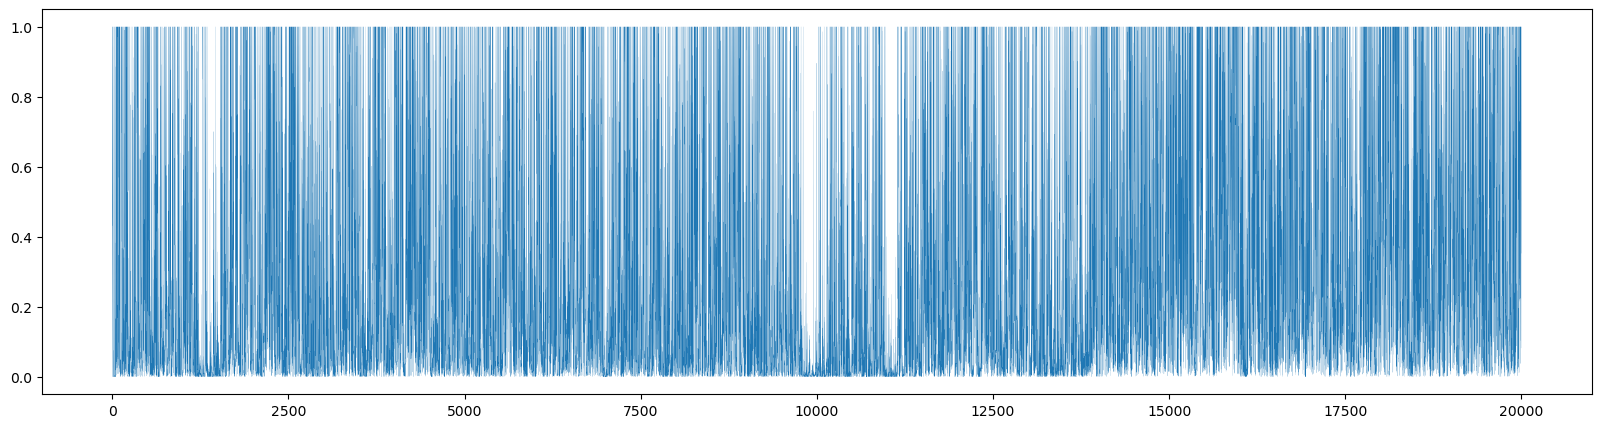

In [68]:
plt.subplots(figsize=(20,5))
plt.plot(a_check, lw=0.1)

In [69]:
np.mean([x[0] for x in a_check2])

0.013211698487998342

In [70]:
[x[0] for x in a_check2][10000:]

[2.065470421089922e-16,
 3.815168279221819e-07,
 5.746904764046256e-09,
 3.7666367033112764e-11,
 5.583234604524528e-08,
 5.891474472201433e-09,
 5.3279090130482414e-08,
 1.1211079571571087e-09,
 1.2943915616594129e-06,
 1.1950622273739078e-07,
 6.172071931420263e-20,
 1.0580212424571098e-09,
 6.068126171945386e-06,
 5.86425506900437e-08,
 9.184206144290604e-10,
 1.0145622608747014e-05,
 1.5704066408846064e-15,
 8.464819304147778e-15,
 3.469410018526814e-09,
 6.897101950807697e-10,
 7.396248388525689e-12,
 2.7751018161494324e-07,
 7.879044949816556e-06,
 3.657483941086824e-05,
 6.216717267165248e-07,
 1.902548794127842e-06,
 5.2058868309393564e-17,
 0.0021481030955219785,
 1.489228120256263e-06,
 6.50912395564579e-06,
 6.126809436516433e-08,
 1.357923710028956e-08,
 0.07094531954136067,
 1.5282155266379937e-06,
 8.918514340627742e-08,
 3.9936102261002975e-05,
 1.0188674259751254e-10,
 5.720007093426832e-11,
 0.002944545054352147,
 2.563953972750908e-10,
 4.6864971770346744e-08,
 1.3853

In [71]:
(a_2 - a_target_2)

-0.25865910789978064

In [72]:
a_2

0.14134089210021936

In [73]:
mc_i

19999

In [74]:
a_check2

[(9.840472495319657e-169, -1362.4777397997427, -975.6273628114774),
 (9.72235080940538e-104, -1207.483349958929, -970.2889277295984),
 (1.0, -950.3265193537068, -970.064855224711),
 (1.7291024087706307e-41, -1044.1378033035621, -950.2794169258116),
 (1.469894856402531e-12, -956.8245282227931, -929.5786979788403),
 (1.1221673890535022e-18, -967.9669016606499, -926.6356319708349),
 (1.371798611037793e-08, -943.5094346120469, -925.4048766016664),
 (7.480834942105452e-16, -960.3565200361041, -925.5275029572325),
 (4.910367474705391e-09, -946.8861349649144, -927.7542179090727),
 (1.0177286388101817e-15, -948.0781895098982, -913.5569864345267),
 (7.980951139514994e-15, -945.3840801222154, -912.9223613220793),
 (5.7616028679501846e-11, -936.1917519064057, -912.6145315951533),
 (6.201947957662677e-07, -927.0046096411897, -912.711377419656),
 (1.9423028547398042e-16, -949.1416170277404, -912.9641298474634),
 (0.0010047771976526426, -919.6768070856224, -912.7738176296956),
 (0.000524451130394916

In [45]:
ll_prop = eval_ll(y_vals_true,
                  x_vals,
                  w_samples_1=w_approx_prop[0:103],
                  w_samples_2=w_approx_prop[103:],
                  sigma_1=sigma_1_prop,
                  sigma_2=sigma_2_prop,
                  tau_grid=tau_grid,
                  tau_grid_expanded=tau_grid_expanded,
                  mu=mu_prop,
                  gamma=gamma_prop,
                  base_quantile_mean=base_quantile_mean,
                  base_quantile_sd=base_quantile_sd,
                  base_quantile_v=1,
                  base_quantile_dist='norm')


In [46]:
y_vals_true = y_vals_true
x_vals = x_vals
w_samples_1=w_approx_prop[0:103]
w_samples_2=w_approx_prop[103:]
sigma_1=sigma_1_prop
sigma_2=sigma_2_prop
tau_grid=tau_grid
tau_grid_expanded=tau_grid_expanded
mu=mu_prop
gamma=gamma_prop
base_quantile_mean=base_quantile_mean
base_quantile_sd=base_quantile_sd
base_quantile_v=1
base_quantile_dist='norm'

In [70]:
log_lik = 0
log_lik_col = []
lik_col = []
for i in prange(0,len(y_vals_true)):

    y_i = y_vals_true[i]
    x_i = x_vals[i]

    ll_i = grid_search_deriv_approx_vector(y_i=y_i,
                          x_i=x_i,
                          w_samples_1=w_samples_1,
                          w_samples_2=w_samples_2,
                          sigma_1=sigma_1,
                          sigma_2=sigma_2,
                          tau_grid=tau_grid,
                          tau_grid_expanded=tau_grid_expanded,
                          mu=mu,
                          gamma=gamma,
                          base_quantile_mean=base_quantile_mean,
                          base_quantile_sd=base_quantile_sd,
                          base_quantile_v=base_quantile_v,
                          base_quantile_dist=base_quantile_dist)

    log_lik += np.log(10)
    lik_col.append(ll_i)
    log_lik_col.append(np.log(ll_i))
log_lik = -1 * log_lik

In [71]:
log_lik

-916.4288670116271

In [68]:
np.log(10)

2.302585092994046

In [52]:
x_i = x_vals[0]
y_i = y_vals_true[0]

In [54]:
Q_y_i_vals

array([-3.79965607, -3.79180303, -3.78396348, -3.77529143, -3.76548203,
       -3.76548203, -3.74382831, -3.73363508, -3.72507272, -3.71869511,
       -3.7145619 , -3.71226777, -3.71226777, -3.71065618, -3.71037839,
       -3.71016352, -3.70995222, -3.70995222, -3.70951111, -3.70931216,
       -3.70931216, -3.7090549 , -3.70899913, -3.70897288, -3.70896166,
       -3.70895701, -3.70895701, -3.70895421, -3.70895382, -3.70895364,
       -3.70895357, -3.70895353, -3.70895351, -3.70895349, -3.70895348,
       -3.70895348, -3.70895342, -3.70895337, -3.70895329, -3.70895315,
       -3.70895283, -3.70895283, -3.70894884, -3.7089354 , -3.70886846,
       -3.70852066, -3.70688186, -3.70688186, -3.68962181, -3.67474463,
       -3.65973573, -3.64565335, -3.63230688, -3.61894337, -3.61894337,
       -3.58818648, -3.56921048, -3.54777231, -3.52478752, -3.50162395,
       -3.47964625, -3.45981471, -3.44239364, -3.42687734, -3.41217451,
       -3.39687316, -3.37945637, -3.35855807, -3.33330039, -3.30

In [56]:
deriv_Q_y

0.5829938980530519

In [58]:
Q_y_edge[0]

-3.074680246143917

In [59]:
Q_y_i_vals[-1]

-3.0805101851244476

In [60]:
y_i

0.774052345967664

In [61]:
Q_y_edge

array([-3.07468025])

In [63]:
np.log(10)

2.302585092994046

In [57]:


Q_y_i_vals = Q_joint_quantile_function_vector(tau_input=tau_grid,
                                          x_vals=x_i,
                                          w_samples_1=w_samples_1,
                                          w_samples_2=w_samples_2,
                                          sigma_1=sigma_1,
                                          sigma_2=sigma_2,
                                          tau_grid=tau_grid_expanded,
                                          mu=mu,
                                          gamma=gamma,
                                          base_quantile_mean=base_quantile_mean,
                                          base_quantile_sd=base_quantile_sd,
                                          base_quantile_v=base_quantile_v,
                                          base_quantile_dist=base_quantile_dist)


t_l = 0
while True:
    if Q_y_i_vals[t_l] > y_i:

        break
    t_l += 1
    if t_l == len(tau_grid):
        break

if t_l >= len(tau_grid)-1:
    print('1')
    tau_edge = 1

    Q_y_edge = Q_joint_quantile_function_vector(tau_input=np.array([tau_edge]),
                                        x_vals=x_i,
                                        w_samples_1=w_samples_1,
                                        w_samples_2=w_samples_2,
                                        sigma_1=sigma_1,
                                        sigma_2=sigma_2,
                                        tau_grid=tau_grid_expanded,
                                        mu=mu,
                                        gamma=gamma,
                                        base_quantile_mean=base_quantile_mean,
                                        base_quantile_sd=base_quantile_sd,
                                        base_quantile_v=base_quantile_v,
                                        base_quantile_dist=base_quantile_dist) 
            
    if y_i > Q_y_edge[0]: # If still outside boundary
        top_diff = 10 # Set to arbitrary big number
    
    else:
        top_diff = Q_y_edge[0] - Q_y_i_vals[-1]
        
    if top_diff < 0:
        print("ERRORRRR", top_diff, Q_y_edge[0], Q_y_i_vals[-1])
        #print('w1: ', w_samples_1)
        #print('w2: ', w_samples_2)


    if top_diff == 0:
        print('asdasd')
        top_diff = 1e-20
    #print("Top: ", top_diff)

    # TODO: This top diff affects alot!!!! expand grid to make value for this
    #top_diff = 0.009990000000000054
    #top_diff = 0.1
    deriv_Q_y = (top_diff)/(tau_edge - tau_grid[t_l-1])


elif t_l == 0:
    print('2')
    tau_edge = 0

    Q_y_edge = Q_joint_quantile_function_vector(tau_input=np.array([tau_edge]),
                                x_vals=x_i,
                                w_samples_1=w_samples_1,
                                w_samples_2=w_samples_2,
                                sigma_1=sigma_1,
                                sigma_2=sigma_2,
                                tau_grid=tau_grid_expanded,
                                mu=mu,
                                gamma=gamma,
                                base_quantile_mean=base_quantile_mean,
                                base_quantile_sd=base_quantile_sd,
                                base_quantile_v=base_quantile_v,
                                base_quantile_dist=base_quantile_dist) 

    if y_1 < Q_y_edge[0]:
        bot_diff = 10 # Set to arbitrary big number
    
    else:
        bot_diff = Q_y_i_vals[0] - Q_y_edge[0]
    if bot_diff == 0:
        print('asd')
        bot_diff = 1e-20
    #print('bot: ', bot_diff)

    #bot_diff = 0.05
    deriv_Q_y = (bot_diff)/(tau_grid[t_l] - tau_edge)
    #print(tau_grid[t_l])


else:
    print('3')
    deriv_Q_y = (Q_y_i_vals[t_l] - Q_y_i_vals[t_l-1])/(tau_grid[t_l] - tau_grid[t_l-1])



1


In [30]:
Q_y_edge

array([0.4593563])

In [58]:
Q_y_i_vals

array([0.22915315, 0.22924776, 0.22928122, 0.22931166, 0.22934392,
       0.22934392, 0.22941366, 0.22945024, 0.22948721, 0.22952394,
       0.22955973, 0.22959382, 0.22959382, 0.22965387, 0.22967843,
       0.22969869, 0.22971451, 0.22971451, 0.22973414, 0.22973931,
       0.22973931, 0.22974631, 0.22976376, 0.22989057, 0.23066735,
       0.23389201, 0.23389201, 0.25182204, 0.263414  , 0.27529019,
       0.28713198, 0.29878197, 0.31012388, 0.32103922, 0.33136656,
       0.33136656, 0.34857834, 0.35359359, 0.35576343, 0.35644108,
       0.35663342, 0.35663342, 0.35673025, 0.35675747, 0.35678467,
       0.35681267, 0.35684119, 0.35684119, 0.35689795, 0.35692547,
       0.35695207, 0.35697757, 0.35700184, 0.35702479, 0.35702479,
       0.35706655, 0.35708531, 0.35710268, 0.35711867, 0.35713332,
       0.35714664, 0.35715871, 0.35716956, 0.35717928, 0.35718794,
       0.35719565, 0.35720252, 0.35720869, 0.35721437, 0.35721992,
       0.35722614, 0.3572351 , 0.35725226, 0.35729139, 0.35738

In [33]:
Q_joint_quantile_function_vector(tau_input=tau_grid,
                                              x_vals=x_i,
                                              w_samples_1=w_samples_1,
                                              w_samples_2=w_samples_2,
                                              sigma_1=sigma_1,
                                              sigma_2=sigma_2,
                                              tau_grid=tau_grid_expanded,
                                              mu=mu,
                                              gamma=gamma,
                                              base_quantile_mean=base_quantile_mean,
                                              base_quantile_sd=base_quantile_sd,
                                              base_quantile_v=base_quantile_v,
                                              base_quantile_dist=base_quantile_dist)

array([0.22915315, 0.22924776, 0.22928122, 0.22931166, 0.22934392,
       0.22934392, 0.22941366, 0.22945024, 0.22948721, 0.22952394,
       0.22955973, 0.22959382, 0.22959382, 0.22965387, 0.22967843,
       0.22969869, 0.22971451, 0.22971451, 0.22973414, 0.22973931,
       0.22973931, 0.22974631, 0.22976376, 0.22989057, 0.23066735,
       0.23389201, 0.23389201, 0.25182204, 0.263414  , 0.27529019,
       0.28713198, 0.29878197, 0.31012388, 0.32103922, 0.33136656,
       0.33136656, 0.34857834, 0.35359359, 0.35576343, 0.35644108,
       0.35663342, 0.35663342, 0.35673025, 0.35675747, 0.35678467,
       0.35681267, 0.35684119, 0.35684119, 0.35689795, 0.35692547,
       0.35695207, 0.35697757, 0.35700184, 0.35702479, 0.35702479,
       0.35706655, 0.35708531, 0.35710268, 0.35711867, 0.35713332,
       0.35714664, 0.35715871, 0.35716956, 0.35717928, 0.35718794,
       0.35719565, 0.35720252, 0.35720869, 0.35721437, 0.35721992,
       0.35722614, 0.3572351 , 0.35725226, 0.35729139, 0.35738

In [133]:
eta_out_1 = eta_function_i_vector(tau_input=tau_grid,
                           w_vals=w_samples_1,
                           tau_grid=tau_grid_expanded,
                           mean=base_quantile_mean,
                           sd=base_quantile_sd,
                           v=base_quantile_v,
                           sigma=sigma_1,
                           dist=base_quantile_dist)

eta_out_2 = eta_function_i_vector(tau_input=tau_grid,
                           w_vals=w_samples_2,
                           tau_grid=tau_grid_expanded,
                           mean=base_quantile_mean,
                           sd=base_quantile_sd,
                           v=base_quantile_v,
                           sigma=sigma_2,
                           dist=base_quantile_dist)

eta_out_1_edge = eta_function_i_vector(tau_input=np.array([tau_edge]),
                           w_vals=w_samples_1,
                           tau_grid=tau_grid_expanded,
                           mean=base_quantile_mean,
                           sd=base_quantile_sd,
                           v=base_quantile_v,
                           sigma=sigma_1,
                           dist=base_quantile_dist)

eta_out_2_edge = eta_function_i_vector(tau_input=np.array([tau_edge]),
                           w_vals=w_samples_2,
                           tau_grid=tau_grid_expanded,
                           mean=base_quantile_mean,
                           sd=base_quantile_sd,
                           v=base_quantile_v,
                           sigma=sigma_1,
                           dist=base_quantile_dist)

In [134]:
eta_out_1_edge[0] - eta_out_1[-1]

-0.004098316821514569

In [135]:
eta_out_2_edge[0] - eta_out_2[-1]

0.0021539497524016987

In [136]:
c_vals = np.exp(w_samples_1)
xi_vals = logistic_transform_vector(tau_grid, tau_grid_expanded, c_vals)
xi_vals2 = logistic_transform_vector(np.array([1]), tau_grid_expanded, c_vals)


In [137]:
norm.ppf(1 - 1e-16,0,1)

8.209536151601387

In [138]:
xi_vals2

array([1.])

In [139]:
xi_vals[-1]

0.9999999999999998

In [140]:
norm.ppf(xi_vals2 - 1e-15)

array([7.94144449])

In [132]:
norm.ppf(xi_vals[-1])

8.125890664701908

In [71]:
xi_vals2[0] - xi_vals[-1]

2.220446049250313e-16

In [49]:
xi_vals[-1]

0.999996443792745

In [41]:
if xi_vals[0] == 0:
    # Find next non zero
    for v in xi_vals[1:]:
        if v > 0:
            break
    if v > 0:
        xi_vals[xi_vals==0] = v - v/2
    else:
        xi_vals[xi_vals==0] = 3.93881666e-294
        
if xi_vals[-1] == 1:

    for v in xi_vals[-2::-1]:
        if v < 1:
            break
    if v < 1:
        xi_vals[xi_vals==1] = v + (1-v)/2
    
    else:
        xi_vals[xi_vals==1] = 1-1e-15

In [42]:
eta_out = numba_norm.ppf(xi_vals,
                             0,
                             1)

In [43]:
eta_out

array([-6.58525946, -6.36046977, -6.11741688, -5.85262811, -5.56765743,
       -5.56765743, -4.9506432 , -4.62702379, -4.29989934, -3.97491935,
       -3.65828174, -3.35662438, -3.35662438, -2.82537878, -2.60809896,
       -2.42884307, -2.28879746, -2.28879746, -2.11516352, -2.06963138,
       -2.06963138, -2.02615939, -2.01726626, -2.01232771, -2.00953202,
       -2.00787433, -2.00787433, -2.00607788, -2.00549753, -2.00498167,
       -2.00445852, -2.00385305, -2.00305799, -2.00188665, -1.99998109,
       -1.99998109, -1.99037341, -1.97837378, -1.95534525, -1.91264888,
       -1.83894118, -1.83894118, -1.56540589, -1.3684578 , -1.14408275,
       -0.90305597, -0.65393696, -0.65393696, -0.15442267,  0.08842119,
        0.32331734,  0.54860208,  0.76308816,  0.96596668,  0.96596668,
        1.33513049,  1.50108645,  1.65467472,  1.79607312,  1.9255397 ,
        2.04340323,  2.15006786,  2.2460276 ,  2.33188258,  2.40834826,
        2.47625062,  2.5365053 ,  2.59008436,  2.63797771,  2.68

In [139]:
test_list = [1,2,3,4,5,6,7]

for x in test_list[-2::-1]:
    print(x)

6
5
4
3
2
1


In [135]:
norm.ppf(xi_vals,0,1)

array([-36.65408784, -36.63518652, -31.60272568, -26.90632208,
       -22.53773298, -22.53773298, -14.74665061, -11.30266616,
        -8.14264831,  -5.25102326,  -2.61799363,  -0.44370534,
        -0.44370534,   2.73104462,   4.35360312,   5.74722797,
         6.87952618,   6.87952618,   7.05711303,   7.05711303,
         7.05711303,   7.05711303,   7.05711303,   7.05711303,
         7.05711303,   7.05711303,   7.05711303,   7.05711303,
         7.05711303,   7.05711303,   7.05711303,   7.05711303,
         7.05711303,   7.05711303,   7.05711303,   7.05711303,
         7.05711303,   7.05711303,   7.05711303,   7.05711303,
         7.05711303,   7.05711303,   7.05711303,   7.05711303,
         7.05711303,   7.05711303,   7.05711303,   7.05711303,
         7.05711303,   7.05711303,   7.05711303,   7.05711303,
         7.05711303,   7.05711303,   7.05711303,   7.05711303,
         7.05711303,   7.05711303,   7.05711303,   7.05711303,
         7.05711303,   7.05711303,   7.05711303,   7.05

# Chain Eval

## Kappa and Lambda

Text(0.5, 1.0, 'Lambda Trace Plot')

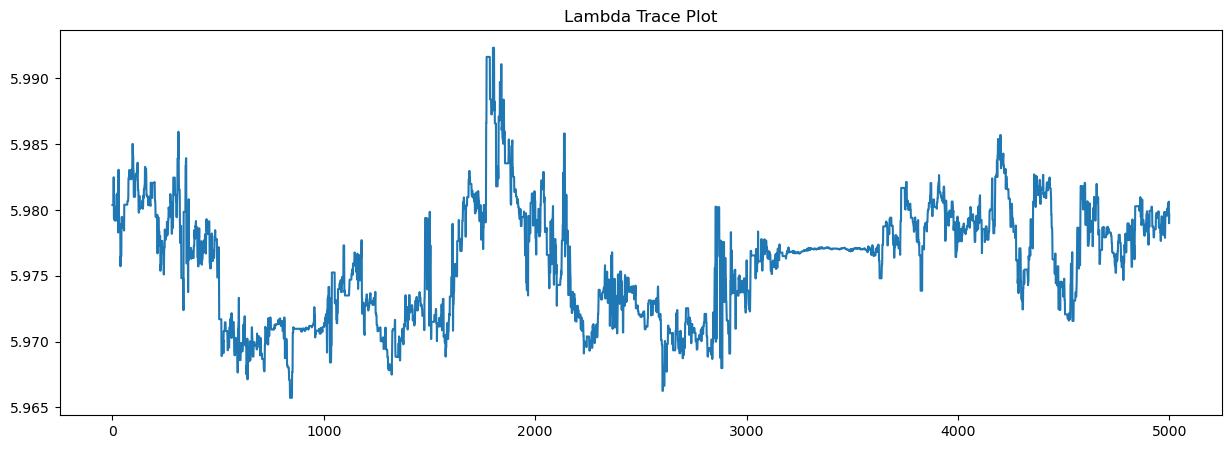

In [111]:
fig, ax = plt.subplots(figsize=(15,5))

n_burn_in = 15000

ax.plot(lambda_store[n_burn_in:])

ax.set_title('Lambda Trace Plot')

#ax.set_ylim(5.9,6)


## Mu Gamma Sigmas

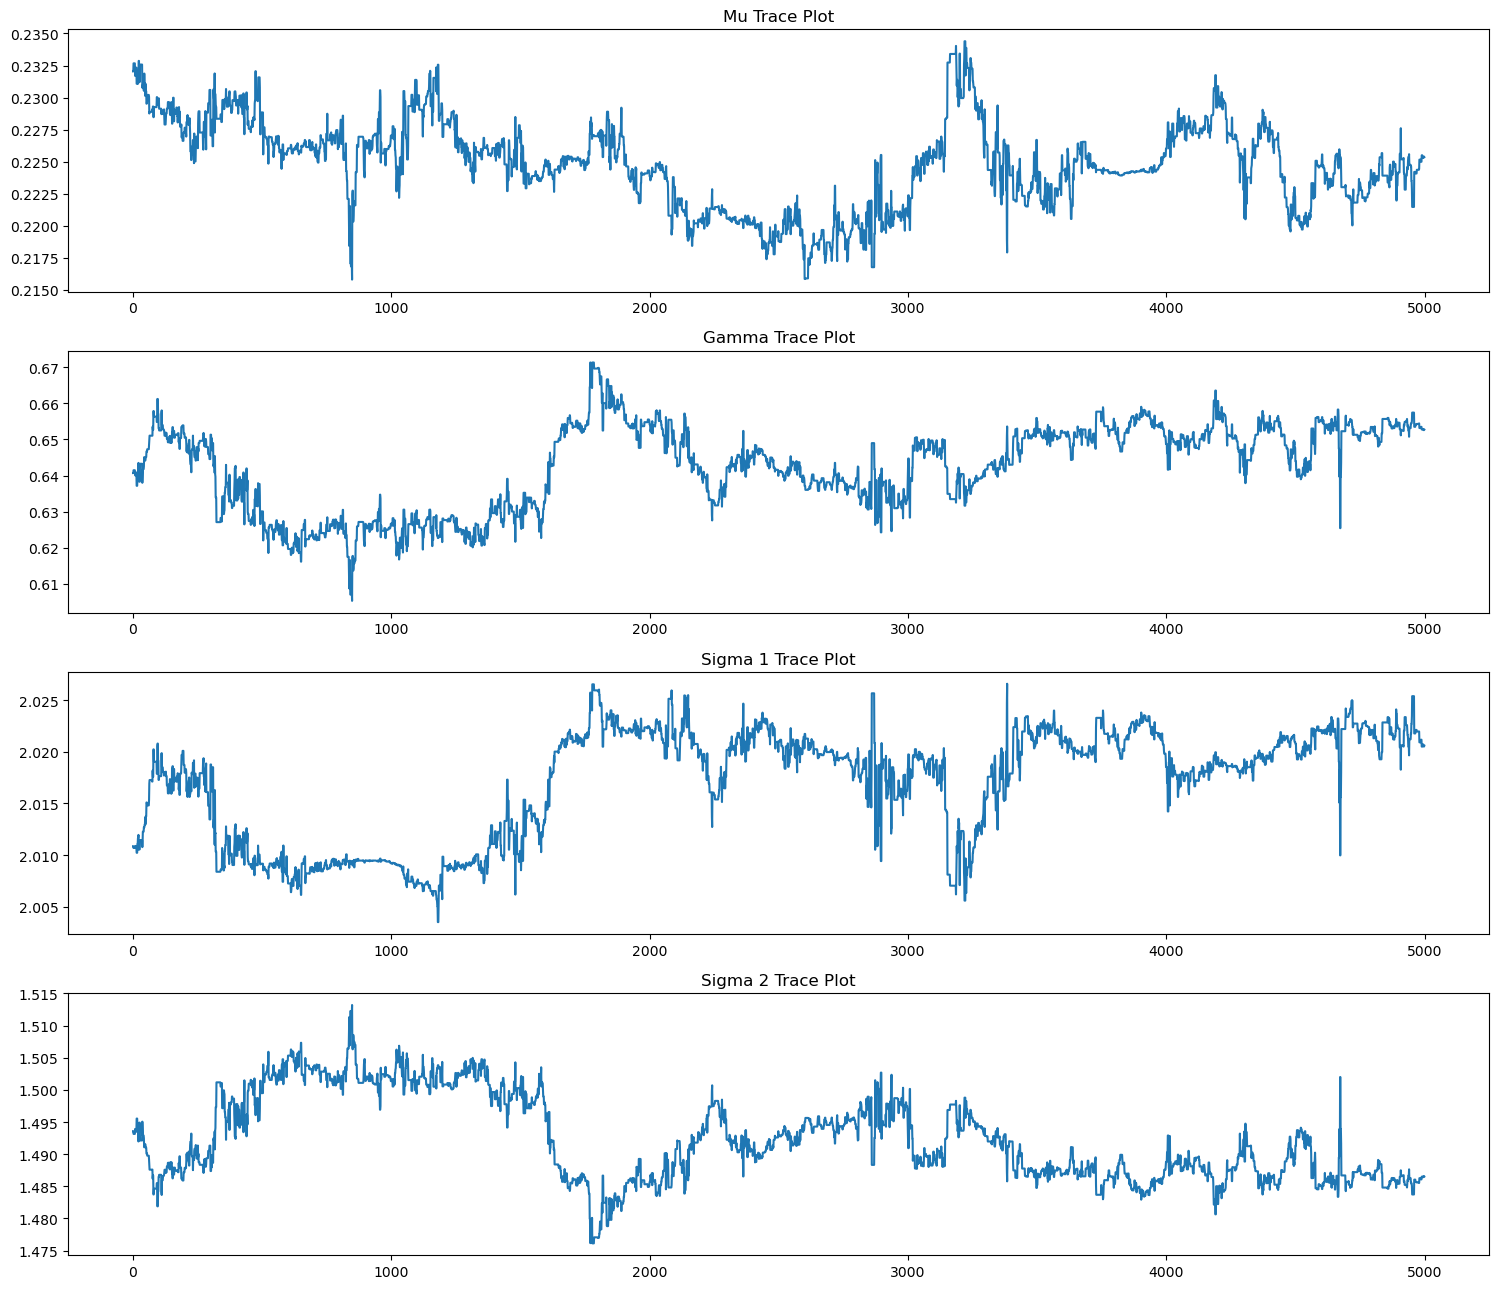

In [112]:
fig, ax = plt.subplots(4,1,figsize=(15,13))

ax[0].plot(mu_store[n_burn_in:])
ax[1].plot(gamma_store[n_burn_in:])
ax[2].plot(sigma_1_store[n_burn_in:])
ax[3].plot(sigma_2_store[n_burn_in:])

ax[0].set_title('Mu Trace Plot')
ax[1].set_title('Gamma Trace Plot')
ax[2].set_title('Sigma 1 Trace Plot')
ax[3].set_title('Sigma 2 Trace Plot')


plt.tight_layout()

In [113]:
100*block_1_accept_cnts/20000
100*block_2_accept_cnts/20000 

40.05

In [114]:
block_2_accept_cnts/20000 

0.4005

In [115]:
log_am_lamb_block2

0.38133952699473195

## Inferred Beta 0 Beta 1 at various tau levels

In [116]:
from typing import List

In [117]:
def generate_beta_samples(tau_input: float,
                          tau_grid: np.ndarray,
                          w_approx_store: List[np.ndarray],
                          mu_store: List[float],
                          gamma_store: List[float],
                          sigma_1_store: List[float],
                          sigma_2_store: List[float]):

    beta_0_store = []
    beta_1_store = []

    for i in range(0,len(w_approx_store)):

        w_samp = w_approx_store[i]
        w1_samp = w_samp[0:103]
        w2_samp = w_samp[103:]

        mu_samp = mu_store[i]
        gamma_samp = gamma_store[i]
        sigma_1_samp = sigma_1_store[i]
        sigma_2_samp = sigma_2_store[i]


        eta_1_samp = eta_function_i_vector(tau_input=np.array([tau_input]),
                                             w_vals=w1_samp,
                                             tau_grid=tau_grid,
                                             mean=0.0,
                                             sd=1.0,
                                             v=1,
                                             sigma=sigma_1_samp,
                                             dist='norm')[0]


        eta_2_samp = eta_function_i_vector(tau_input=np.array([tau_input]),
                                             w_vals=w2_samp,
                                             tau_grid=tau_grid,
                                             mean=0.0,
                                             sd=1.0,
                                             v=1,
                                             sigma=sigma_2_samp,
                                             dist='norm')[0]


        beta_0_samp = mu_samp + (eta_1_samp + eta_2_samp)/2
        beta_1_samp = gamma_samp + (eta_2_samp - eta_1_samp)/2

        beta_0_store.append(beta_0_samp)
        beta_1_store.append(beta_1_samp)
        
    return beta_0_store, beta_1_store

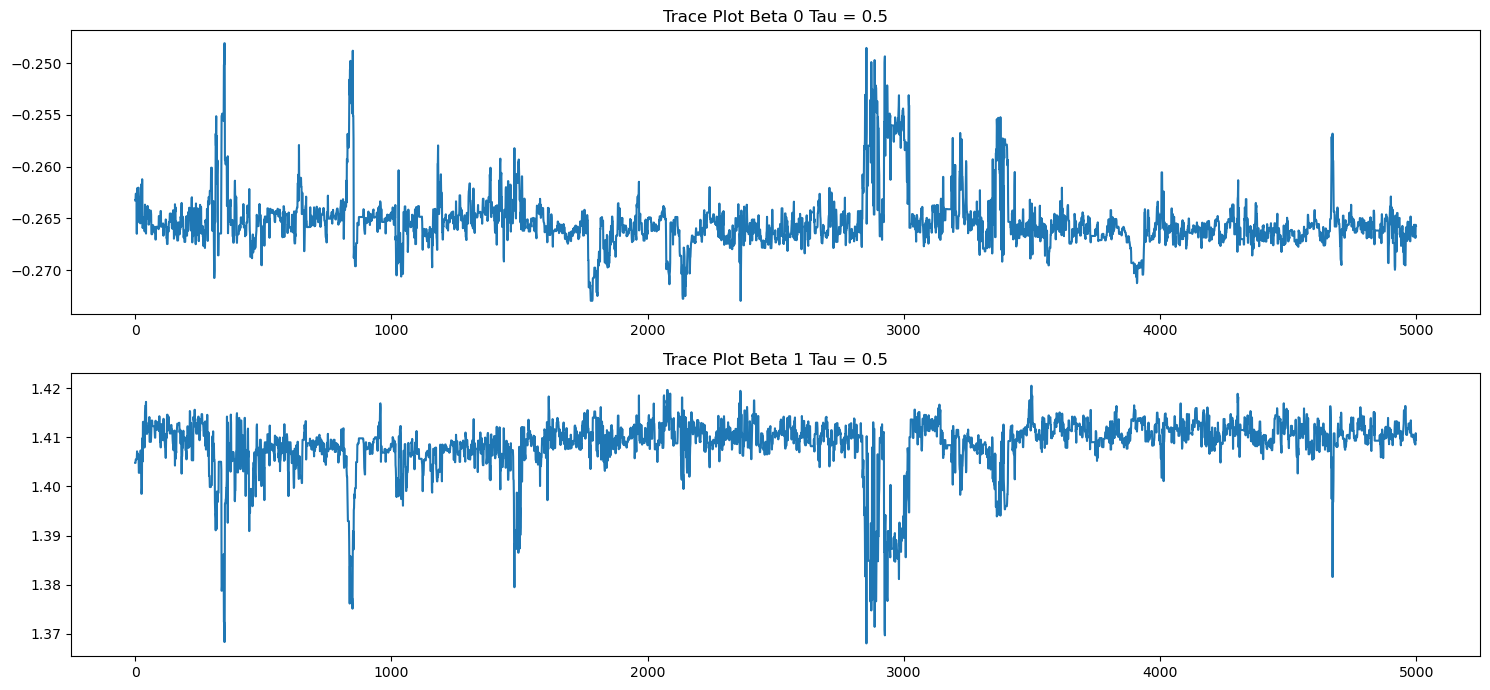

In [118]:
fig,ax = plt.subplots(2,1, figsize=(15,7))

input_tau = 0.5

beta_0_samps, beta_1_samps = generate_beta_samples(tau_input=input_tau,
                                                  tau_grid=tau_grid_expanded,
                                                  w_approx_store=w_approx_store,
                                                  mu_store=mu_store,
                                                  gamma_store=gamma_store,
                                                  sigma_1_store=sigma_1_store,
                                                  sigma_2_store=sigma_2_store)

ax[0].plot(beta_0_samps[n_burn_in:])
ax[1].plot(beta_1_samps[n_burn_in:])

ax[0].set_title('Trace Plot Beta 0 Tau = '+str(input_tau))
ax[1].set_title('Trace Plot Beta 1 Tau = '+str(input_tau))
plt.tight_layout()

Plot Example lines

In [119]:
y_pred_samples = np.array([b0 + b1*x_vals for b0,b1 in zip(beta_0_samps, beta_1_samps)])
y_pred_samples = y_pred_samples[n_burn_in:]

Text(0, 0.5, 'Y')

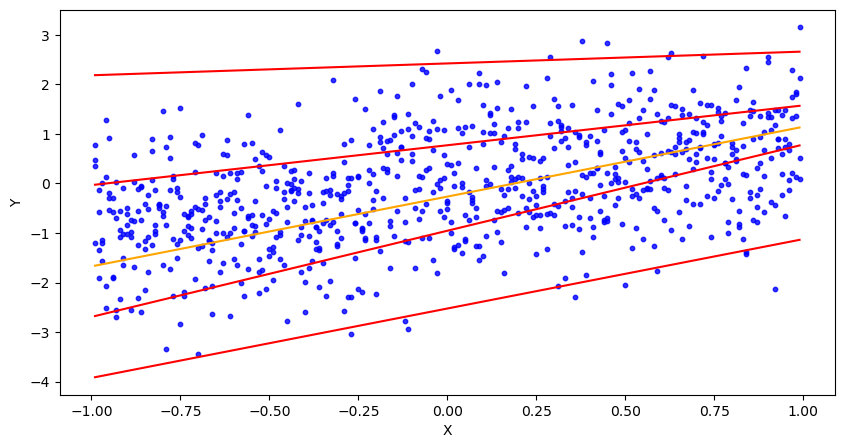

In [122]:
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(x_vals, y_vals_true, s=10, color='blue', alpha=0.8)

#sample_quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
sample_quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
#sample_quantiles = [0.5]
for sq in sample_quantiles:
    
    beta_0_samps, beta_1_samps = generate_beta_samples(tau_input=sq,
                                                      tau_grid=tau_grid_expanded,
                                                      w_approx_store=w_approx_store,
                                                      mu_store=mu_store,
                                                      gamma_store=gamma_store,
                                                      sigma_1_store=sigma_1_store,
                                                      sigma_2_store=sigma_2_store)
    
    y_pred_samples = np.array([b0 + b1*x_vals for b0,b1 in zip(beta_0_samps, beta_1_samps)])
    y_pred_samples = y_pred_samples[n_burn_in:]
    
    if sq == 0.5:
        c = 'orange'
    else:
        c = 'red'
    ax.plot(x_vals, y_pred_samples.mean(0), color=c)


ax.set_xlabel('X')
ax.set_ylabel('Y')